In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cmocean.cm as cmo
import xarray as xr

In [2]:
setup = "ESII_SO"
confi = "RCSI100.L55_ctlv30_030W"

## We need to contruct the bathymetries for our idealized experiments

First, the depth axis. We load an axis created with `construct_vertical_grid.ipynb` following the method proposed by [Stewart et al., 2017](https://github.com/kialstewart/vertical_grid_for_ocean_models/blob/master/build_vertical_grid_kds.py). 

In [3]:
ds_z_axis = xr.open_dataset(setup + "-" + confi + "-vertical_grid.nc", engine='h5netcdf')
dz = ds_z_axis["drF"].values # thickness of cells
H_ = np.sum(dz)
rF = ds_z_axis["Zl"].values # depth of upper cell faces
z = ds_z_axis["Z"].values # depth of vertical cell centers
H_int = int(H_)

Now the bathymetry

In [4]:
##### number of cells in x and y directions
x_num_cells = 240
y_num_cells = 320

# horizontal grid spacing
dx = 10
dy = 10

# x and y axes in km
x_in_km = np.linspace(int(dx/2), x_num_cells * dx - int(dx/2), x_num_cells)
y_in_km = np.linspace(int(dy/2), y_num_cells * dy - int(dy/2), y_num_cells)

# maximum depth of bathymetry
max_depth = np.sum(dz)
H = -max_depth

# simple bathymetry, depth H everywhere
bathy = np.ones((y_num_cells, x_num_cells)) * H

# add shelf
shelf_depth = 300 # depth of the shelf in m
shelf_slope_center = 400 # central position of the slope in km
shelf_slope_width = 120 # slope half width in km
Hs = -shelf_depth
shelf_out = (Hs + (0.5 * (H - Hs)) * (1 + np.tanh((y_in_km - shelf_slope_center) / shelf_slope_width)))
bathy = shelf_out[:, None] * np.ones((y_num_cells, x_num_cells))

bathy[0, :] = 0 # construct a wall at the southern boundary
bathy[bathy > -dz[0:3].sum()] = 0 # make sure there are at least three cells in the vertical everywhere where there is water

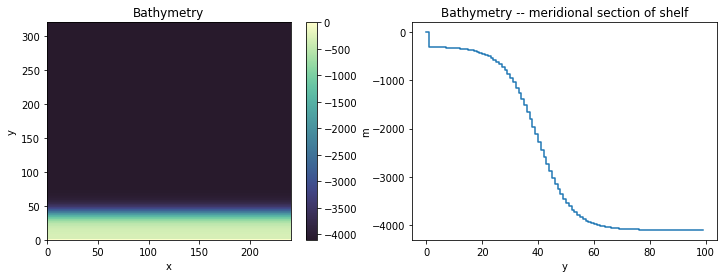

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))

p0 = axs[0].pcolormesh(bathy, cmap=cmo.deep_r)
plt.colorbar(p0, ax=axs[0], label="m")
axs[0].set_title("Bathymetry")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

p1 = axs[1].step(np.arange(0, 100), bathy[0:100,0], where="post")
axs[1].set_title("Bathymetry -- meridional section of shelf")
axs[1].set_xlabel("y");

In [8]:
# thickness of sponge layer to build the restoring mask
sponge_size = int(100 / dy)
ones_size = int(20 / dy)

sponge = (np.tanh(np.linspace(-3, 3, sponge_size)) + 1) / 2

mask = np.zeros((1, len(dz), y_num_cells, x_num_cells))
mask[:, 1:len(dz) + 1, -ones_size::, :] = 1.0
mask[:, 1:len(dz) + 1, -(sponge_size + ones_size):-ones_size, :] = sponge[None, None, :, None]

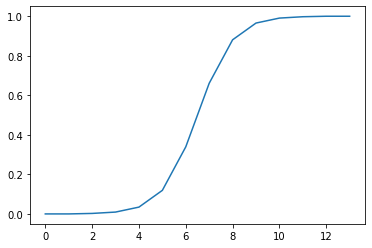

In [9]:
plt.plot(mask[0, 1, 306::, 0])

In [10]:
bathy.astype(">f4").tofile(setup + '-' + confi + '-bathymetry_shelf.bin')
mask.astype(">f4").tofile(setup + '-' + confi + '-restoring_mask_with_sponge.bin')

In [11]:
ds = xr.Dataset(data_vars = {"bathy": (("y", "x"), bathy),
                             "restoring_mask_with_sponge": (("t", "z", "y", "x"), mask)},
                coords = {"z": (("z"), z),
                          "y": (("y"), np.linspace(dy / 2, (y_num_cells * dy) - dy / 2, y_num_cells)),
                          "x": (("x"), np.linspace(dx / 2, (x_num_cells * dx) - dx / 2, x_num_cells))})
ds["bathy"].attrs = {"standard_name": "sea_floor_depth_below_reference_ellipsoid",
                     "long_name": "bathymetry",
                     "units": "m",
                     "positive": "up"}
ds["z"].attrs = {"standard_name": "depth", 
                 "long_name": "vertical coordinate of cell center",
                 "units": "m",
                 "positive": "up",
                 "axis": "Z"}
ds["y"].attrs = {"long_name": "y coordinate",
                 "units": "km",
                 "axis": "Y",
                 "grid_spacing": dy}
ds["x"].attrs = {"long_name": "x coordinate",
                 "units": "km",
                 "axis": "X",
                 "grid_spacing": dx}

In [12]:
ds.to_netcdf(setup + '-' + confi + '-bathymetry_and_mask.nc', engine='h5netcdf')

/home/jrieck/.venv/py39/lib/python3.9/site-packages/h5netcdf/core.py:481: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  h5ds.dims.create_scale(h5ds, scale_name)
